## Importing necessary libraries

### Make sure all necessary libraries are also installed.

In [ ]:
# Essential Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import seaborn as sns
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset, IterableDataset
from sklearn.decomposition import TruncatedSVD


# Other libraries
import string
import random
import copy
from tqdm.auto import tqdm
import warnings
from collections import defaultdict
from functools import wraps

# for type hint
from typing import Tuple, List, Optional

sns.set_theme(style="darkgrid")
warnings.filterwarnings('ignore')

## Defining Hyper-parameters

In [ ]:
BATCH_SIZE = 2048
NUM_NEGATIVE_SAMPLES = 5
WINDOW_SIZE = 4

## Datasets

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, num_sentences=10_000, batch_size=BATCH_SIZE, split="train"):
    self.rawdata = load_dataset("bookcorpus", split=split, streaming=True)
    self.new_data = list()

    # useful things :)
    self.batch_size = batch_size
    self.num_sentences = num_sentences
    self.word2idx = dict()
    self.current_index = 0 # for updating word2idx

    # execute
    self._make_new_dataset()
    self.idx2word = {k: v for v, k in self.word2idx.items()}
    self.vocab_size = len(self.word2idx)

  def __len__(self, ):
    return len(self.new_data)

  def __getitem__(self,
                  idx: int):
    return self.new_data[idx]


  def __replace_unnecessary(self, sen):
    to_replace = "1234567890<>?[]{}_-+=&^%$#@!~`:;|"
    for char in to_replace:
      sen = sen.replace(char, '')

    sen = sen.replace('\\', '')
    sen = sen.replace('//', '')
    return sen

  def _clean(self,
             sentences:List[str]):
    """
    Cleans the raw dataset. Extracts the text part of the sentences in the dataset.
    Also updates the word2idx
    """
    out = list()
    for sentence in sentences:
      text = sentence["text"]
      text = self.__replace_unnecessary(text)
      out.append(text) # list of sentences

    # mapping
    for sentence in out:
      for word in sentence.split():
        word = str(word) # there are numbers too which are causing problems later :( it's just a ugly fix
        if word not in self.word2idx.keys():
          self.word2idx[word] = self.current_index
          self.current_index += 1

    return out

  def _make_new_dataset(self):
    """
    Makes new dataset from the given dataset.
    The dataset was really huge, and we only need some sentences.
    """
    temp_dataloader = DataLoader(self.rawdata, batch_size=self.batch_size, collate_fn=self._clean)
    dataset_size = self.num_sentences // self.batch_size

    for sentences in temp_dataloader:
      self.new_data.extend(sentences)
      dataset_size -= 1
      if dataset_size == 0:
        break

In [ ]:
dataset = CustomDataset(num_sentences=100, batch_size=2)
vocab_size = dataset.vocab_size
word2idx = dataset.word2idx
idx2word = dataset.idx2word

dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
word2idx["standing"]

192

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


## Making the dataset for model training

In [ ]:
class TrainDataset(Dataset):
  def __init__(self,
               dataset: torch.utils.data.Dataset,
               window_size: int,
               sentences_dataloader: torch.utils.data.DataLoader,
               negative_samples: int = 0,):
    """
    Dataset for traning Language model
    Args:
      dataset: The corrosponding dataset of the dataloader
      window_size: The context_window size
      sentences_dataloader: The dataloder which returns list of sentences
      negative_samples: Number of negative samples to generate per word

    Returns:
      ?
    """

    self.old_dataset = dataset
    self.dataloader = sentences_dataloader
    self.negative_samples = negative_samples
    self.window_size =window_size

    self.negative_sampling = True if self.negative_samples != 0 else False

    # List of tuples i.e. (context_word, center_word, 0/1)
    self.dataset = list() # the new dataset
    self.execute()

  def __len__(self, ):
    return len(self.dataset)

  def __def_value(self):
    # idk some error in code ig, so for now making it 1
    return 1

  def __getitem__(self, idx):
    center_word, context_word, relation = self.dataset[idx]
    w2i = self.old_dataset.word2idx
    center_word, context_word, relation = torch.tensor(w2i[str(center_word)]), torch.tensor(w2i[str(context_word)]), torch.tensor(relation)
    return center_word, context_word, relation

  def execute(self,):
    """
    Execute all the necessary steps
    """
    self.freq_counts = self.__create_freq_dict()
    if self.negative_sampling:
      self.neg_dict = self.__create_neg_dict()

    # execute to make new dataset
    self.__make_dataset()


  def __generate_samples(self, sentences):
    for sen in sentences:
      words = sen.split()
      for idx, center_word in enumerate(words[self.window_size: len(words)-self.window_size-1]):
        context_words = [context_word for context_word in words[idx: idx+self.window_size*2-1] if context_word != center_word]

        # Subsampling
        for context_word in context_words:
          if not self.__to_discard(context_word):
            continue

          self.dataset.append((center_word, context_word, 1))

        # Negative sampling
        if self.negative_sampling:
          neg_samples = self.__choose_negative_examples()
          for neg_sample in neg_samples:
            self.dataset.append((center_word, neg_sample, 0))

  def __make_dataset(self):
    for sentences in self.dataloader:
      self.__generate_samples(sentences)


  def __choose_negative_examples(self):
    negative_words = []
    return random.choices(list(self.neg_dict.keys()),
                          weights=list(self.neg_dict.values()),
                          k=self.negative_samples)


  def __discarding_prob(self, word, threshold=1e-5) -> float:
    """
    Given a word it returns the probability of discarding it.
    It is for subsampling
    The Probability is given by:
      P = 1 - sqrt(1/word_frequency)

    Args:
      word: Word for which we want the discarding probability
    """
    return 1 - np.sqrt(threshold / self.freq_counts[str(word)])

  def __to_discard(self, word, threshold=1e-5) -> bool:
    """
    Returns False to not discard the words and vice-versa
    """
    discarding_probability = self.__discarding_prob(word, threshold)
    deciding_prob = random.uniform(0, 1)
    return False if discarding_probability > deciding_prob else True

  def __create_neg_dict(self, ):
    neg_dict = self.__create_freq_dict(normalize=False)
    z = 0
    for k, v in neg_dict.items():
      neg_dict[k] = v ** (3/4)
      z += neg_dict[k]

    for k, b in neg_dict.items():
      neg_dict[k] /= z

    return neg_dict

  def __create_freq_dict(self, normalize=True):
    """
    calculating the frequency of each unique_word in the corpus
    then normalizing it (cause it is directly realed to the subsampling formula)
    """
    freq_counts = defaultdict(self.__def_value)
    total_frequency = 0
    for sentences in self.dataloader:
      temp = ''.join(sentences)
      for word in word2idx.keys():
        freq_counts[word] += temp.count(word)
        total_frequency += 1

    # Normalizing the frequency values
    if normalize:
      for k, v in freq_counts.items():
        freq_counts[k] = v/total_frequency
    return freq_counts


In [ ]:
temp_dataset = CustomDataset()
temp_dataloader = DataLoader(dataset=temp_dataset, batch_size=BATCH_SIZE, shuffle=True)

dataset = TrainDataset(window_size = 2,
                       dataset = temp_dataset,
                       sentences_dataloader = temp_dataloader,
                       negative_samples = 1)
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
center_words, context_words, relations = next(iter(dataloader))
type(center_words), type(context_words), type(relations)

(torch.Tensor, torch.Tensor, torch.Tensor)

## Models

In [ ]:
class BaseModel(nn.Module):
  """
  Abstract class for other models :).
  """
  def __init__(self, ):
    super().__init__()
    self.embd_layer = None # have to overrite this for visualization function

  def visualize(self,
                idx2word,
                title:str = "Default",
                axes=None,
                words: int=-1):
    svd = TruncatedSVD(n_components=2, random_state=41)
    embs = self.embd_layer.weight.data.detach().cpu()

    if words != -1:
      embs = embs[:words]
    else:
      print(f"Provide words parameter...")
      return

    new_embs = svd.fit_transform(embs)
    total_words = new_embs.shape[0]
    if not axes:
      for i in range(total_words):
        plt.scatter(new_embs[i, 0], new_embs[i, 1], marker="x", color="red")
        plt.annotate(idx2word[i], (new_embs[i, 0], new_embs[i, 1]))
        plt.title(title, fontweight="bold", color="blue")
    else:
      for i in range(total_words):
        axes.scatter(new_embs[i, 0], new_embs[i, 1], marker="x", color="red")
        axes.annotate(idx2word[i], (new_embs[i, 0], new_embs[i, 1]))
        axes.set_title(title, fontweight="bold", color="blue")

  def base_train(self,
                 inputs,
                 loss_fn,
                 device):
    """
    Overwrite this for specific model
    Returns the loss
    """
    print("Implement this...")
    raise NotImplementedError

  def plot_loss(self, axes=None, title="Training"):
    if not axes:
      plt.plot(range(len(self.losses)), self.losses, label="losses (per-batch)")
      plt.title(title)
      plt.legend()

    else:
      axes.plot(range(len(self.losses)), self.losses, label="losses (per-batch)")
      axes.set_title(title)
      axes.legend()

  # training name is not working idk why :(
  def t(self,
            *,
            epochs,
            optimizer,
            dataloader,
            device,
            loss_fn,
            stats = True):
    """
    Function to train the model
    """
    if stats:
      # Currently they are per-batch
      self.losses = []
      self.acc = []

    self.to(device)
    self.train()
    for epoch in tqdm(range(epochs)):
      for inputs in dataloader:
        optimizer.zero_grad()

        # Model specific
        loss = self.base_train(inputs, loss_fn, device)
        if stats:
          self.losses.append(loss.item())

        loss.backward()
        optimizer.step()


In [ ]:
class Word2Vec(BaseModel):
    def __init__(self, emb_dim=300, vocab_size=vocab_size):
        super().__init__()
        self.embd_layer = nn.Embedding(vocab_size, emb_dim)

    def base_train(self,
                   inputs,
                   loss_fn,
                   device):
      center_words, context_words, relations = inputs
      relations = relations.type(torch.float32)
      center_words, context_words, relations = center_words.to(device), context_words.to(device), relations.to(device)
      probs = self(context_words, center_words)
      loss = loss_fn(probs, relations)
      return loss

    def forward(self, context_words, center_words):
      context_emb = self.embd_layer(context_words) # (batch_size, emb_dim)
      center_emb = self.embd_layer(center_words) # (batch_size, emb_dim)
      return F.sigmoid(torch.sum((context_emb * center_emb), dim=1)) # (batch_size)

word2vec = Word2Vec()
word2vec

Word2Vec(
  (embd_layer): Embedding(533, 300)
)

## Datasets & Dataloader (For training and Inference) (word2vec)

In [ ]:
# Some Hyperparameters
BATCH_SIZE = 2048
NUM_NEGATIVE_SAMPLES = 2
WINDOW_SIZE = 4


# For training (word2vec)
temp_train_dataset = CustomDataset(split="train")
temp_train_dataloader = DataLoader(dataset=temp_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

def get_hparams(dataset):
  return dataset.vocab_size, dataset.word2idx, dataset.idx2word

train_vocab_size, train_word2idx, train_idx2word = get_hparams(temp_train_dataset)
train_data = TrainDataset(dataset=temp_train_dataset,
                          window_size = WINDOW_SIZE,
                          sentences_dataloader = temp_train_dataloader,
                          negative_samples = NUM_NEGATIVE_SAMPLES)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)


## Training Word2Vec using skip-gram

In [ ]:
center_words, context_words, relations = next(iter(train_dataloader))
untrained_word2vec = Word2Vec(vocab_size=train_vocab_size)
word2vec = Word2Vec(vocab_size=train_vocab_size)

optimizer = torch.optim.AdamW(params=word2vec.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

word2vec.t(epochs=10,
               optimizer=optimizer,
               device=device,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               stats=True)

  0%|          | 0/10 [00:00<?, ?it/s]

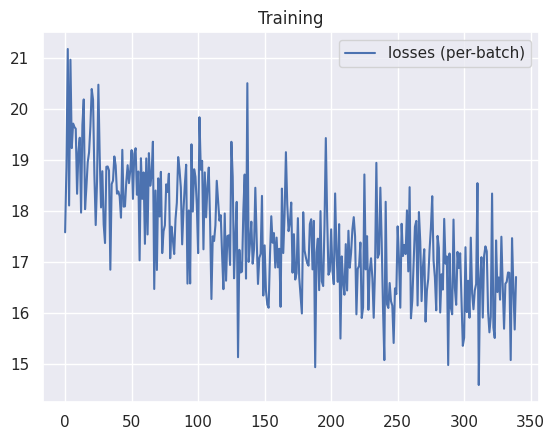

In [ ]:
word2vec.plot_loss()

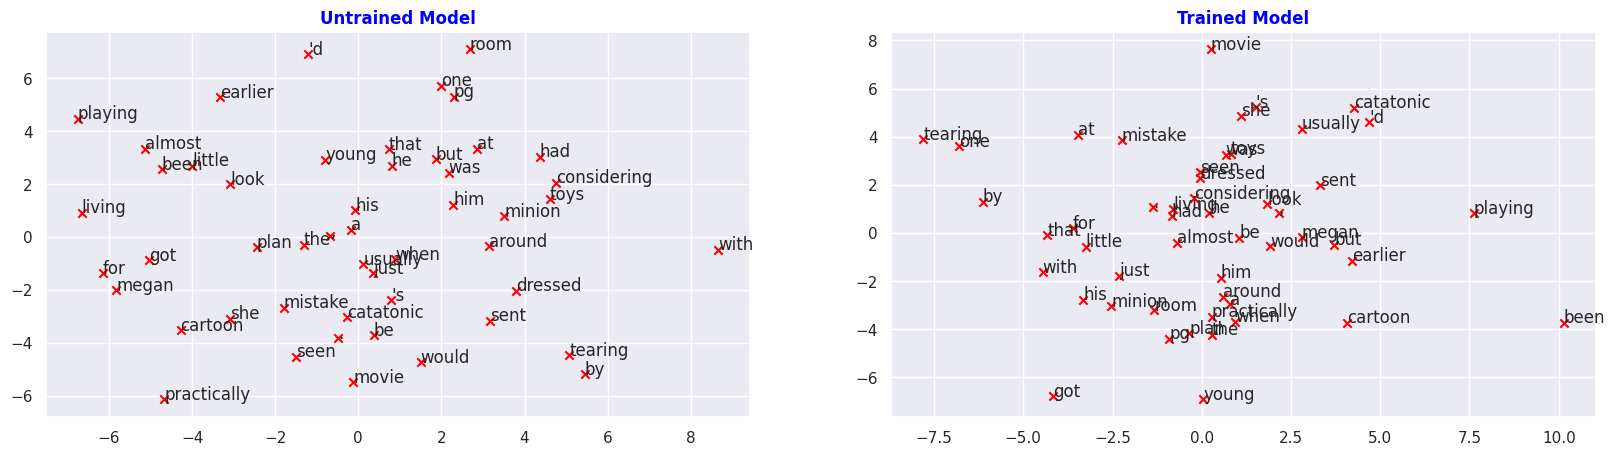

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

untrained_word2vec.visualize(words=50, title="Untrained Model", axes=ax[0], idx2word=train_idx2word)
word2vec.visualize(words=50, title="Trained Model", axes=ax[1], idx2word=train_idx2word)

## CBOW

In [ ]:
class CBOW(BaseModel):
  """
  Given context words predict center word.
  """
  def __init__(self, emb_dim=300, vocab_size=vocab_size):
    super().__init__()
    self.embd_layer = nn.Embedding(vocab_size, emb_dim)
    self.linear = nn.Linear(emb_dim, vocab_size)

  def base_train(self,
                  inputs,
                  loss_fn,
                  device):
    center_words, context_words, relations = inputs
    relations = relations.type(torch.float32)
    center_words, context_words, relations = center_words.to(device), context_words.to(device), relations.to(device)


    probs = self(context_words)
    loss = loss_fn(probs, center_words)
    return loss

  def forward(self, context_words):
    context_emb = self.embd_layer(context_words)
    return self.linear(context_emb)


In [ ]:
# Some Hyperparameters
BATCH_SIZE = 2048
NUM_NEGATIVE_SAMPLES = 0
WINDOW_SIZE = 4


# For training (word2vec)
temp_train_dataset = CustomDataset(num_sentences=100_000, split="train")
temp_train_dataloader = DataLoader(dataset=temp_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

def get_hparams(dataset):
  return dataset.vocab_size, dataset.word2idx, dataset.idx2word

train_vocab_size, train_word2idx, train_idx2word = get_hparams(temp_train_dataset)
train_data = TrainDataset(dataset=temp_train_dataset,
                          window_size = WINDOW_SIZE,
                          sentences_dataloader = temp_train_dataloader,
                          negative_samples = NUM_NEGATIVE_SAMPLES)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)


In [ ]:
center_words, context_words, relations = next(iter(train_dataloader))
untrained_cbow = CBOW(vocab_size=train_vocab_size)
cbow = CBOW(vocab_size=train_vocab_size)

optimizer = torch.optim.AdamW(params=word2vec.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

cbow.t(epochs=100,
               optimizer=optimizer,
               device=device,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               stats=True)

  0%|          | 0/100 [00:00<?, ?it/s]

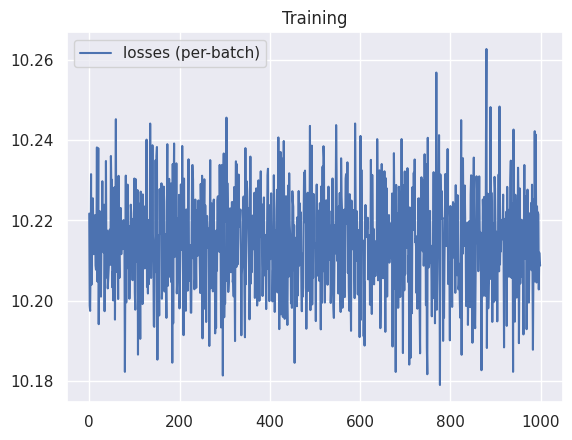

In [ ]:
cbow.plot_loss()

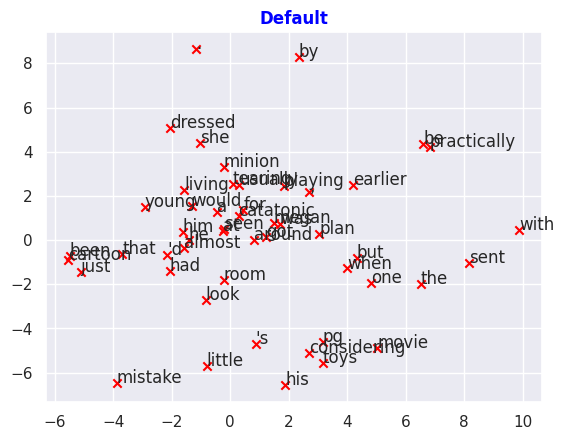

In [ ]:
cbow.visualize(words=50, idx2word=train_idx2word)

## Glove